# Retina Analysis

__By Sheila Brooks and Osarodion Ogbebor Evans__

### __Executive Summary/Problem Description:__
Retinal imaging, the process of taking high-resolution images of the rear inner surface of the eye, is used by ophthalmologists to examine the eyes. Some of the features captured during this process are; the optic nerve, fovea, surrounding vessels, and the retinal layer. (The STARE Project, n.d.)

In this project, we will be building on the work done by Michael H. Goldbaum, M.D., Professor of Ophthalmology in Residence, Shiley Eye Institute, and Adam Hoover, Department of Electrical and Computer Engineering, Clemson University, to predict the diagnoses of 400 retinal images.


In [4]:
conda install keras

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##




==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda






  environment location: C:\Users\osaro\anaconda3\envs\aap

  added / updated specs:
    - keras


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    keras-2.4.3                |       hd3eb1b0_0           6 KB
    keras-base-2.4.3           |     pyhd3eb1b0_0          30 KB
    ------------------------------------------------------------
                                           Total:          36 KB

The following NEW packages will be INSTALLED:

  keras              pkgs/main/noarch::keras-2.4.3-hd3eb1b0_0
  keras-base         pkgs/main/noarch::keras-base-2.4.3-pyhd3eb1b0_0




keras-base-2.4.3     | 30 KB     |            |   0% 
keras-base-2.4.3     | 30 KB     | #####2     |  53% 
keras-base-2.4.3     | 30 KB     | ########## | 100% 
keras-base-2.4.3     | 30 KB     | ########## | 100% 

keras-2.4.3          | 6 KB      |            |   0% 
keras-2.4.3          | 6 KB      | #######

### Data Prep

Please refer to `convertImages.ipynb` in the `convertImages` folder.

In [5]:
import sys
import os, os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib.image import imread
from tensorflow import keras
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from PIL import Image

## Exploratory Data Analysis

In [7]:
# Function to append .jpeg to imageIDs in testLabels.csv and trainLabels.csv
def append_ext(fn):
    return fn+".jpeg"

In [8]:
# Read csvs and apply function to append .jpeg to imageIDs
traindf=pd.read_csv("Data/trainLabels.csv",dtype=str)
testdf=pd.read_csv("Data/testLabels.csv",dtype=str)
traindf["imageID"]=traindf["imageID"].apply(append_ext)
testdf["imageID"]=testdf["imageID"].apply(append_ext)

In [9]:
traindf.head()

,imageID,label
0,im0001.jpeg,Background Diabetic Retinopathy
1,im0002.jpeg,Choroidal Neovascularization
2,im0003.jpeg,Drusen
3,im0004.jpeg,Drusen
4,im0005.jpeg,Background Diabetic Retinopathy


In [10]:
testdf.head()

,imageID,label
0,im0351.jpeg,Choroidal Neovascularization
1,im0352.jpeg,Choroidal Neovascularization
2,im0353.jpeg,Choroidal Neovascularization
3,im0354.jpeg,Choroidal Neovascularization
4,im0355.jpeg,Drusen


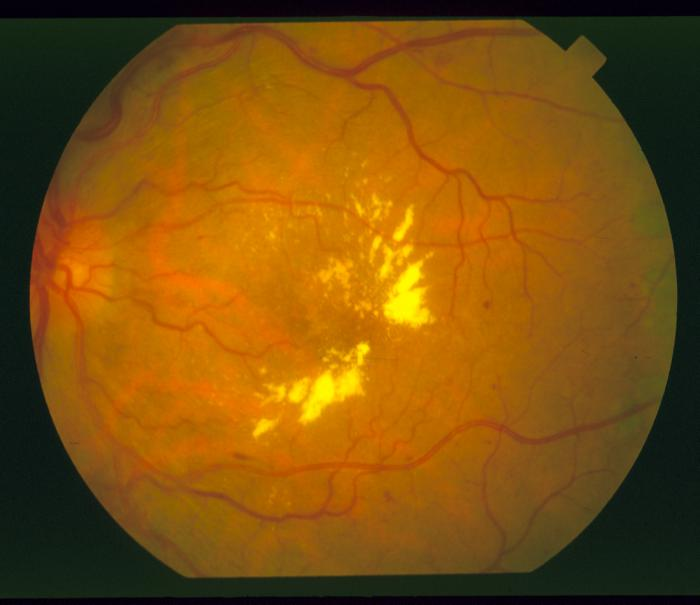

In [12]:
# view image one image
from IPython.display import Image
Image(r"Data/train_images/im0001.jpeg")

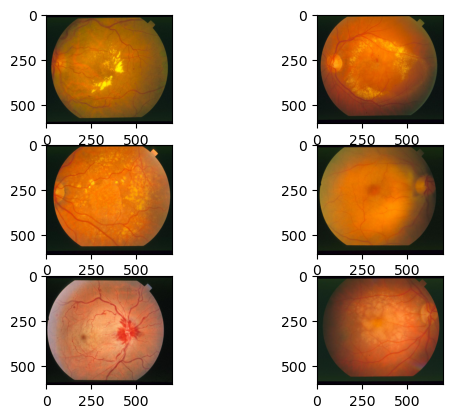

In [13]:
# View 6 different images
img_dir=r"Data/train_images"
all_files=os.listdir(img_dir)
data_path = [os.path.join(img_dir + "/" + i) for i in all_files]
k=0

for i in data_path:
    if k > 5:
        break
    else:
        k=k+1
        plt.subplot(3,2,k) 
        plt.imshow(imread(i))
plt.show()

In [14]:
# Compare the number of train and test images to the labels 
print(f"The shape of train label: {traindf.shape}.")
train_img_path = r"Data/train_images"
print(f"Number of train images in train folder: {len([image for image in os.listdir(train_img_path) if os.path.isfile(os.path.join(train_img_path, image))])}")

print(f"The shape of test labels: {testdf.shape}.")
test_img_path = r"Data/test_images"
print(f"Number of test images in test folder: {len([image for image in os.listdir(test_img_path) if os.path.isfile(os.path.join(test_img_path, image))])}")


The shape of train label: (350, 2).
Number of train images in train folder: 350
The shape of test labels: (52, 2).
Number of test images in test folder: 52


In [15]:
# View count of diagnoses in Train
print(traindf.groupby(['label'])['label'].count())
print(f"The sum is: {traindf.groupby(['label'])['label'].count().sum()}.")

label
Background Diabetic Retinopathy    123
Choroidal Neovascularization        98
Drusen                              87
Normal                              42
Name: label, dtype: int64
The sum is: 350.


In [16]:
# View count of diagnoses in Test
print(testdf.groupby(['label'])['label'].count())

print(f"The sum is: {testdf.groupby(['label'])['label'].count().sum()}.")

label
Background Diabetic Retinopathy     8
Choroidal Neovascularization       29
Drusen                             15
Name: label, dtype: int64
The sum is: 52.


## Model

In [19]:
# Use generator function from https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

# Rescale and set train-validation split
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

# create generator for train and validation by mapping train labels to train images
# class_mode="sparse" for integer labels
train_generator=datagen.flow_from_dataframe(dataframe=traindf, directory="Data/train_images/", x_col="imageID", y_col="label",
                                            subset="training", batch_size=10, seed=42, shuffle=True, class_mode="sparse",
                                            target_size=(500,500))
valid_generator=datagen.flow_from_dataframe(dataframe=traindf, directory="Data/train_images/", x_col="imageID", y_col="label",
                                            subset="validation", batch_size=10, seed=42, shuffle=True, class_mode="sparse",
                                            target_size=(500,500))

# Rescale test dataset
test_datagen=ImageDataGenerator(rescale=1./255.)

# create generator for test dataset by mapping test labels to test images
# class_mode="none" - no target to be returned because dataset to be used for predict
test_generator=test_datagen.flow_from_dataframe(dataframe=testdf, directory="Data/test_images/", x_col="imageID", y_col=None, batch_size=10,
                                                seed=42, shuffle=False, class_mode=None, target_size=(500,500))

Found 263 validated image filenames belonging to 4 classes.
Found 87 validated image filenames belonging to 4 classes.
Found 52 validated image filenames.


In [20]:
# Model building
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(500, 500, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
    ])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0

In [21]:
# print(train_generator.n)
# print(train_generator.batch_size)
# print(train_generator.n//train_generator.batch_size) #Division rounded to the nearest whole number

In [22]:
hist=model.fit(train_generator,
               validation_data=valid_generator,
               epochs=20)

Epoch 1/20
27/27 [==============================] - 29s 1s/step - loss: 1.8083 - accuracy: 0.3308 - val_loss: 1.3679 - val_accuracy: 0.2644
Epoch 2/20
27/27 [==============================] - 29s 1s/step - loss: 1.2852 - accuracy: 0.4106 - val_loss: 1.5776 - val_accuracy: 0.2529
Epoch 3/20
27/27 [==============================] - 29s 1s/step - loss: 1.2788 - accuracy: 0.4373 - val_loss: 1.6580 - val_accuracy: 0.2529
Epoch 4/20
27/27 [==============================] - 31s 1s/step - loss: 1.2175 - accuracy: 0.4677 - val_loss: 1.4629 - val_accuracy: 0.2989
Epoch 5/20
27/27 [==============================] - 32s 1s/step - loss: 1.1903 - accuracy: 0.5133 - val_loss: 1.4069 - val_accuracy: 0.2414
Epoch 6/20
27/27 [==============================] - 32s 1s/step - loss: 1.2353 - accuracy: 0.4563 - val_loss: 1.5075 - val_accuracy: 0.2299
Epoch 7/20
27/27 [==============================] - 34s 1s/step - loss: 1.1235 - accuracy: 0.4981 - val_loss: 1.6604 - val_accuracy: 0.1839
Epoch 8/20
27/27 [==

In [23]:
# test_loss, test_acc = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_TEST)
test_loss, test_acc = model.evaluate(valid_generator, verbose=2)
print(f"Loss: {test_loss}")
print(f"Acc: {test_acc}")

9/9 - 2s - loss: 4.6047 - accuracy: 0.2184
Loss: 4.604668140411377
Acc: 0.2183908075094223


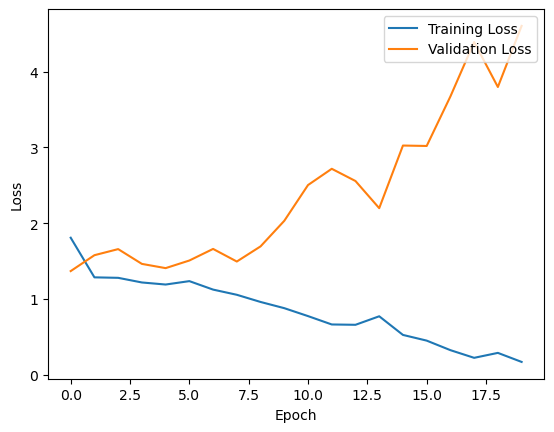

In [24]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

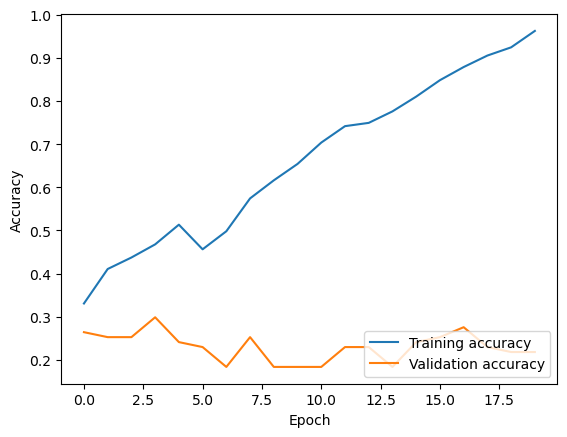

In [25]:
plt.plot(hist.history['accuracy'], label='Training accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [26]:
# Predit test_images
test_generator.reset()
pred=model.predict(test_generator, verbose=1)

6/6 [==============================] - 1s 149ms/step


In [27]:
# Get the predicted indices
predicted_class_indices=np.argmax(pred,axis=1)
print(predicted_class_indices)

[1 0 1 1 0 1 1 1 2 1 1 0 1 0 0 1 2 0 0 3 1 1 3 1 1 0 0 0 2 1 1 1 0 0 3 0 1
 2 0 2 1 1 1 0 1 1 0 1 1 2 0 0]


In [28]:
# Get the labels for the corresponding indices
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [31]:
# Save predicted images to csv
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("Output/results.csv",index=False)

In [33]:
# For analysis, include the actual labels of the predicted images and save to a different csv
predicted_df = pd.read_csv("Output/results.csv")
predicted_df["label"] = testdf["label"]
predicted_df.to_csv("Output/pred_actual.csv",index=False)